In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting seed for reproducability
np.random.seed(1234)
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras import Input
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, SimpleRNN, GRU, Activation, LeakyReLU
%matplotlib inline

# Считывание данных

In [3]:
# считывание тренировочных данных
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [4]:
# считывание тестовых данных
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [5]:
# read ground truth data
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [6]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


# Обработка данных

In [7]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [8]:
# generate label columns for training data
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


In [9]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [10]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


In [11]:
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [12]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


In [13]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


# Моделирование

In [14]:
# pick a large window size of 50 cycles
sequence_length = 50

In [15]:
# preparing data for visualizations 
# window of 50 cycles prior to a failure point for engine id 3
engine_id19 = test_df[test_df['id'] == 19]
engine_id19_50cycleWindow = engine_id19[engine_id19['RUL'] <= engine_id19['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id19_50cycleWindow1 = engine_id19_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id19_50cycleWindow2 = engine_id19_50cycleWindow[cols2]

In [16]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [17]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [18]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [19]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 25)

In [20]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [21]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [22]:
def get_prediction_results(y_pred, batch_s=200):
    for i in range(len(y_pred)):
        y_pred[i][0] = round(y_pred[i][0])
    return y_pred

In [23]:
# Создадим словарь для результатов обучения моделей
models_results = {}

# LSTM

In [67]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [68]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 100)           50400     
                                                                 
 dropout_6 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


In [71]:
%%time
# fit the network
history_lstm=model.fit(seq_array, label_array, epochs=10, batch_size=300, validation_split=0.05, verbose=1)

Epoch 1/10
50/50 [==============================] - 22s 447ms/step - loss: 0.2799 - accuracy: 0.8821 - val_loss: 0.1365 - val_accuracy: 0.9450
Epoch 2/10
50/50 [==============================] - 21s 421ms/step - loss: 0.1100 - accuracy: 0.9570 - val_loss: 0.0772 - val_accuracy: 0.9706
Epoch 3/10
50/50 [==============================] - 26s 520ms/step - loss: 0.0785 - accuracy: 0.9677 - val_loss: 0.0454 - val_accuracy: 0.9808
Epoch 4/10
50/50 [==============================] - 28s 559ms/step - loss: 0.0776 - accuracy: 0.9679 - val_loss: 0.0491 - val_accuracy: 0.9757
Epoch 5/10
50/50 [==============================] - 24s 475ms/step - loss: 0.0694 - accuracy: 0.9709 - val_loss: 0.0460 - val_accuracy: 0.9821
Epoch 6/10
50/50 [==============================] - 25s 496ms/step - loss: 0.0643 - accuracy: 0.9730 - val_loss: 0.0868 - val_accuracy: 0.9655
Epoch 7/10
50/50 [==============================] - 27s 532ms/step - loss: 0.0673 - accuracy: 0.9728 - val_loss: 0.0599 - val_accuracy: 0.9731

In [27]:
for key in history_lstm.history.keys():
    print(key,': ',history_lstm.history[key][-1])

loss :  0.05846510827541351
accuracy :  0.976227343082428
val_loss :  0.046487655490636826
val_accuracy :  0.9795396327972412


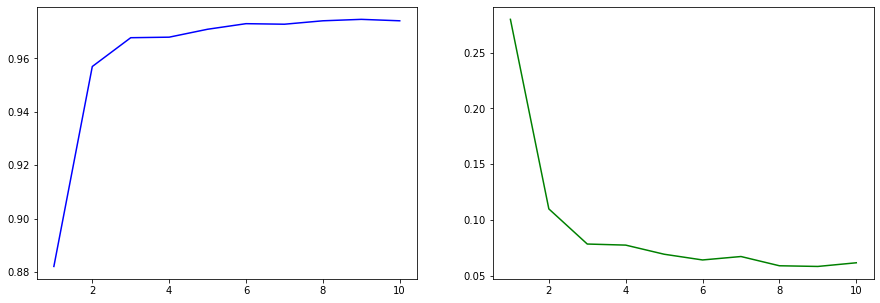

In [72]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(list(range(1,len(history_lstm.history['accuracy']) + 1)), history_lstm.history['accuracy'], c='b')
ax2.plot(list(range(1,len(history_lstm.history['loss']) + 1)), history_lstm.history['loss'], c='g')
plt.show()

In [28]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 12s 157ms/step - loss: 0.0521 - accuracy: 0.9790
Accurracy: 0.9790160655975342


In [29]:
# make predictions and compute confusion matrix
y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_pred = get_prediction_results(y_pred)
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

79/79 [==============================] - 14s 152ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12404,   127],
       [  201,  2899]], dtype=int64)

In [30]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'Precision = ', precision, '\n', 'Recall = ', recall)

Precision =  0.958030403172505 
 Recall =  0.9351612903225807


In [31]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 25)

In [32]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [33]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [34]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 25)
(93, 1)


In [35]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.0982 - accuracy: 0.9462 - 100ms/epoch - 33ms/step
Accurracy: 0.9462365508079529


In [36]:
# make predictions and compute confusion matrix
y_pred_test = model.predict(seq_array_test_last)
y_pred_test = get_prediction_results(y_pred_test)
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[66,  2],
       [ 3, 22]], dtype=int64)

In [37]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.9166666666666666 
 Recall:  0.88 
 F1-score: 0.8979591836734694


In [38]:
models_results['LSTM'] = { 'Accuracy': scores_test[1], 'Precision': precision_test, 'Recall': recall_test, 'F1-score': f1_test }

# RNN

In [73]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(SimpleRNN(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(SimpleRNN(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 100)           12600     
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                7550      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 20,201
Trainable params: 20,201
Non-trainable params: 0
_________________________________________________________________
None


In [74]:
%%time
# fit the network
history_rnn=model.fit(seq_array, label_array, epochs=10, batch_size=300, validation_split=0.05, verbose=1)

Epoch 1/10
50/50 [==============================] - 12s 194ms/step - loss: 0.3222 - accuracy: 0.8600 - val_loss: 0.1944 - val_accuracy: 0.9297
Epoch 2/10
50/50 [==============================] - 6s 126ms/step - loss: 0.1354 - accuracy: 0.9450 - val_loss: 0.1457 - val_accuracy: 0.9399
Epoch 3/10
50/50 [==============================] - 6s 124ms/step - loss: 0.1152 - accuracy: 0.9540 - val_loss: 0.1180 - val_accuracy: 0.9450
Epoch 4/10
50/50 [==============================] - 7s 142ms/step - loss: 0.1086 - accuracy: 0.9535 - val_loss: 0.1052 - val_accuracy: 0.9463
Epoch 5/10
50/50 [==============================] - 6s 127ms/step - loss: 0.0891 - accuracy: 0.9622 - val_loss: 0.1602 - val_accuracy: 0.9386
Epoch 6/10
50/50 [==============================] - 7s 129ms/step - loss: 0.0799 - accuracy: 0.9671 - val_loss: 0.0770 - val_accuracy: 0.9655
Epoch 7/10
50/50 [==============================] - 6s 124ms/step - loss: 0.0784 - accuracy: 0.9669 - val_loss: 0.0681 - val_accuracy: 0.9693
Epoch

In [42]:
for key in history_rnn.history.keys():
    print(key,': ',history_rnn.history[key][-1])

loss :  0.06988105922937393
accuracy :  0.9698969721794128
val_loss :  0.08649879693984985
val_accuracy :  0.970588207244873


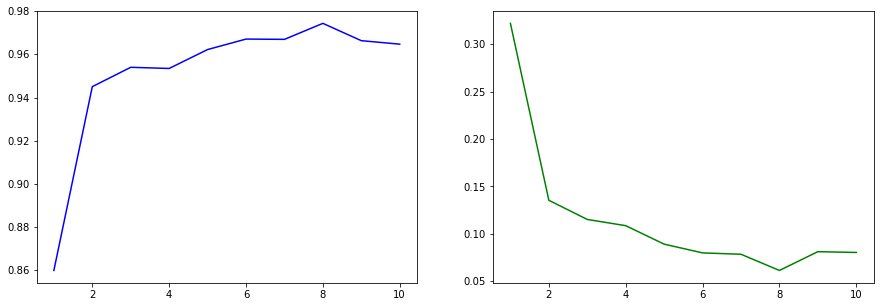

In [75]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(list(range(1,len(history_rnn.history['accuracy']) + 1)), history_rnn.history['accuracy'], c='b')
ax2.plot(list(range(1,len(history_rnn.history['loss']) + 1)), history_rnn.history['loss'], c='g')
plt.show()

In [43]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 4s 55ms/step - loss: 0.0689 - accuracy: 0.9717
Accurracy: 0.9717228412628174


In [44]:
# make predictions and compute confusion matrix
y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_pred = get_prediction_results(y_pred)
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

79/79 [==============================] - 5s 53ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12486,    45],
       [  397,  2703]], dtype=int64)

In [45]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'Precision = ', precision, '\n', 'Recall = ', recall)

Precision =  0.9836244541484717 
 Recall =  0.8719354838709678


In [46]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.1257 - accuracy: 0.9677 - 84ms/epoch - 28ms/step
Accurracy: 0.9677419066429138


In [47]:
# make predictions and compute confusion matrix
y_pred_test = model.predict(seq_array_test_last)
y_pred_test = get_prediction_results(y_pred_test)
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[68,  0],
       [ 3, 22]], dtype=int64)

In [48]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  1.0 
 Recall:  0.88 
 F1-score: 0.9361702127659575


In [49]:
models_results['RNN'] = { 'Accuracy': scores_test[1], 'Precision': precision_test, 'Recall': recall_test, 'F1-score': f1_test }

# GRU

In [76]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(GRU(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [51]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 100)           38100     
                                                                 
 dropout_4 (Dropout)         (None, 50, 100)           0         
                                                                 
 gru_1 (GRU)                 (None, 50)                22800     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 60,951
Trainable params: 60,951
Non-trainable params: 0
_________________________________________________________________
None


In [77]:
%%time
# fit the network
history_gru=model.fit(seq_array, label_array, epochs=10, batch_size=300, validation_split=0.05, verbose=1)

Epoch 1/10
50/50 [==============================] - 27s 405ms/step - loss: 0.3030 - accuracy: 0.8737 - val_loss: 0.1815 - val_accuracy: 0.9182
Epoch 2/10
50/50 [==============================] - 20s 407ms/step - loss: 0.1404 - accuracy: 0.9403 - val_loss: 0.1417 - val_accuracy: 0.9361
Epoch 3/10
50/50 [==============================] - 21s 410ms/step - loss: 0.1141 - accuracy: 0.9535 - val_loss: 0.0775 - val_accuracy: 0.9680
Epoch 4/10
50/50 [==============================] - 16s 325ms/step - loss: 0.0704 - accuracy: 0.9698 - val_loss: 0.0549 - val_accuracy: 0.9770
Epoch 5/10
50/50 [==============================] - 21s 416ms/step - loss: 0.0669 - accuracy: 0.9723 - val_loss: 0.0631 - val_accuracy: 0.9719
Epoch 6/10
50/50 [==============================] - 20s 393ms/step - loss: 0.0671 - accuracy: 0.9708 - val_loss: 0.0512 - val_accuracy: 0.9783
Epoch 7/10
50/50 [==============================] - 19s 372ms/step - loss: 0.0555 - accuracy: 0.9760 - val_loss: 0.0503 - val_accuracy: 0.9808

In [90]:
for key in history_gru.history.keys():
    print(key,': ',history_gru.history[key][-1])

loss :  0.14117050170898438
accuracy :  0.9384470582008362
val_loss :  0.1286441832780838
val_accuracy :  0.9411764740943909


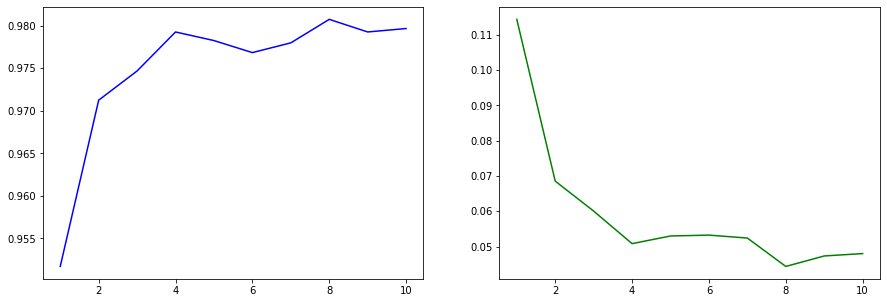

In [78]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(list(range(1,len(history.history['accuracy']) + 1)), history.history['accuracy'], c='b')
ax2.plot(list(range(1,len(history.history['loss']) + 1)), history.history['loss'], c='g')
plt.show()

In [91]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 4s 47ms/step - loss: 0.1339 - accuracy: 0.9393
Accurracy: 0.9392873048782349


In [92]:
# make predictions and compute confusion matrix
y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_pred = get_prediction_results(y_pred)
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

79/79 [==============================] - 4s 48ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[11914,   617],
       [  332,  2768]], dtype=int64)

In [93]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'Precision = ', precision, '\n', 'Recall = ', recall)

Precision =  0.817725258493353 
 Recall =  0.8929032258064517


In [94]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.1824 - accuracy: 0.9355 - 51ms/epoch - 17ms/step
Accurracy: 0.9354838728904724


In [82]:
# make predictions and compute confusion matrix
y_pred_test = model.predict(seq_array_test_last)
y_pred_test = get_prediction_results(y_pred_test)
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[67,  1],
       [ 1, 24]], dtype=int64)

In [83]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.96 
 Recall:  0.96 
 F1-score: 0.96


In [84]:
models_results['GRU'] = { 'Accuracy': scores_test[1], 'Precision': precision_test, 'Recall': recall_test, 'F1-score': f1_test }

# Таблица с результатами

In [85]:
results_df = pd.DataFrame([[models_results['LSTM']['Accuracy'],models_results['LSTM']['Precision'],
                            models_results['LSTM']['Recall'],models_results['LSTM']['F1-score']],
                           [models_results['RNN']['Accuracy'],models_results['RNN']['Precision'],
                            models_results['RNN']['Recall'],models_results['RNN']['F1-score']],
                           [models_results['GRU']['Accuracy'],models_results['GRU']['Precision'],
                            models_results['GRU']['Recall'],models_results['GRU']['F1-score']],
                          [0.94, 0.952381, 0.8, 0.869565]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM', 'RNN', 'GRU', 'Template Best Model'])
results_df

,Accuracy,Precision,Recall,F1-score
LSTM,0.946237,0.916667,0.88,0.897959
RNN,0.967742,1.000000,0.88,0.936170
GRU,0.967742,0.960000,0.96,0.960000
Template Best Model,0.940000,0.952381,0.80,0.869565
